In [1]:
#This is a hack to make the %%cpp work inside mybinder.org - ignore
from ROOT import TObject

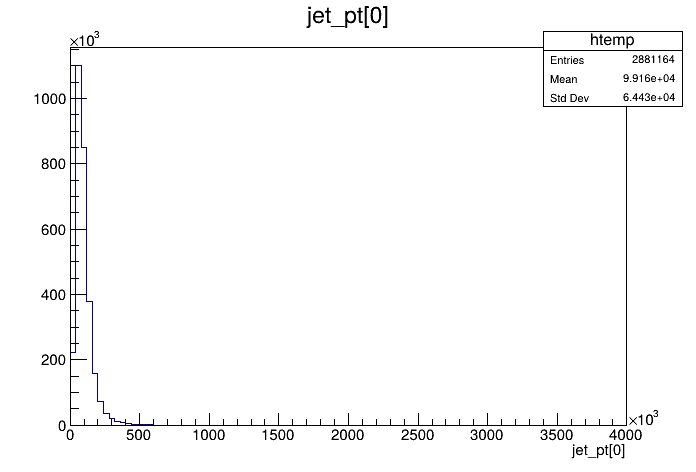

In [3]:
%%cpp
//Recall we can read a file, get the TTree from it and draw something
ttBarFile = TFile::Open("https://atlas-opendata.web.cern.ch/Legacy13TeV/2lep/MC/mc_410000.ttbar_lep.2lep.root");
miniTree = static_cast<TTree*>(ttBarFile->Get("mini;1"));
TCanvas can;
miniTree->Draw("jet_pt[0]");
can.Draw()

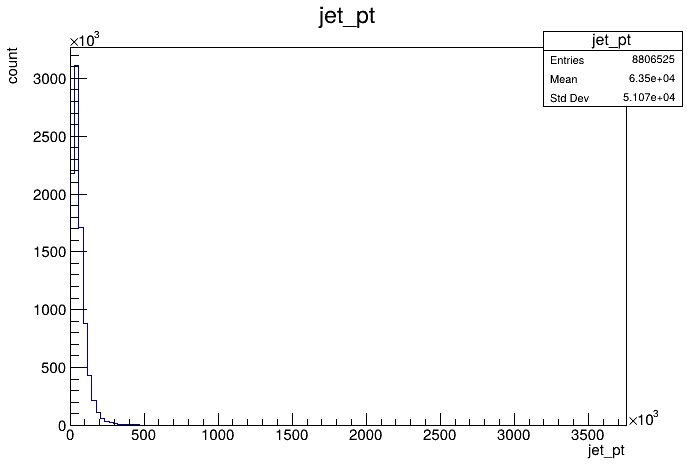

In [4]:
%%cpp
//Another way to do the same thing uses a RDataFrame
ROOT::RDataFrame myDataFrame("mini;1", "https://atlas-opendata.web.cern.ch/Legacy13TeV/2lep/MC/mc_410000.ttbar_lep.2lep.root");
auto myHist = myDataFrame.Histo1D("jet_pt");
can.Clear();
myHist->Draw();
can.Draw()

In [5]:
#Lets repeat in python
from ROOT import RDataFrame, TCanvas
myPythonDataFrame = RDataFrame("mini;1", "https://atlas-opendata.web.cern.ch/Legacy13TeV/2lep/MC/mc_410000.ttbar_lep.2lep.root")
myPythonHist = myPythonDataFrame.Histo1D("jet_n")
myPythonCanvas = TCanvas()
myPythonHist.Draw()
myPythonCanvas.Draw()

TypeError: Template method resolution failed:
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(string_view vName) =>
    SegmentationViolation: segfault in C++; program state was reset
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(const ROOT::RDF::TH1DModel& model, string_view vName, string_view wName) =>
    TypeError: takes at least 3 arguments (1 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(string_view vName, string_view wName) =>
    TypeError: takes at least 2 arguments (1 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, string_view vName = "") =>
    TypeError: could not convert argument 1

[/opt/hep/root/6.32.00.patches/lib/libcppyy_backend.so] (anonymous namespace)::TExceptionHandlerImp::HandleException(int) (no debug info)
[/opt/hep/root/6.32.00.patches/lib/libCore.so] TUnixSystem::DispatchSignals(ESignals) (no debug info)
[/usr/lib/system/libsystem_platform.dylib] _sigtramp (no debug info)
[/usr/lib/system/libunwind.dylib] unw_set_reg (no debug info)
[/usr/lib/libc++abi.dylib] __gxx_personality_v0 (no debug info)
[/usr/lib/system/libunwind.dylib] unwind_phase2 (no debug info)
[/usr/lib/system/libunwind.dylib] _Unwind_Resume (no debug info)
[/opt/hep/root/6.32.00.patches/lib/libROOTDataFrame.so] ROOT::Internal::RDF::GetValidatedColumnNames(ROOT::Detail::RDF::RLoopManager&, unsigned int, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>> const&, ROOT::Internal::RDF::RColumnRegister const&, ROOT::RDF::RDataSource*)

 *** Break *** segmentation violation


In [ ]:
#We see above the number of jets varies by event
#What if we want to plot the jet_pt for events with exactly four jets?
#We do the same thing and add a Filter - the string should be c++ style code (will crash if its invalid..)
myJetPtHist = myPythonDataFrame.Filter("4 == jet_n").Histo1D("jet_pt")
myJetPtHist.Draw()
myPythonCanvas.Draw()

In [ ]:
#What if we want to plot the leading jet pt only, rather than pt of all jets? Asking to draw jet_pt[0] won't work
#So instead we have to define the variable ourselves and we also filter the data to remove events without jets
#Otherwise accessing jet_pt[0] would cause a crash due to an invalid entry in the array.
myNewDataFrame = myPythonDataFrame.Filter("jet_n > 0").Define("leadingJetPt","return jet_pt[0]")
myLeadingJetPtHist = myNewDataFrame.Histo1D("leadingJetPt")
myLeadingJetPtHist.Draw()
myPythonCanvas.Draw()
#We see this is identical to the histogram we made from the TTree at the start of this workbook.

In [ ]:
#Task 1 - create a new data frame with a typical semi-leptonic ttbar event selection consisting of
#exactly one lepton, at least four jets and at least one b-tagged jet
#Then plot the HT variable - this is the scalar sum of jet pt and Missing ET
#Hints: Information about the variables in the open data is here:
#http://opendata.atlas.cern/release/2020/documentation/datasets/dataset13.html

In [ ]:
%%cpp
//What if we want to filter our data using variables not part of the TTree?
//We use lambda capture functions.
//First define a cut value to use
float ptCut = 20;
//Then define a lambda function - it looks like usual in c++, except for the [&ptCut] which
//"captures" our ptCut variable above and uses it in the function
//But note that the standard c++ is as follows:
//auto ptCutFunction = [&ptCut](double pt){return pt > ptCut;};
//whilst in CLING it won't work if you explicitly ask to capture, though it captures anyway.
auto ptCutFunction = [](double pt){return pt > ptCut;};
//Then we first make sure we only use data with 2 jets and 1 lepton
auto myFilteredData = myDataFrame.Filter("jet_n >= 2 && lep_n > 1");
//Now use the lambda function inside the Filter function - just name the function and tell
//it the name of the variable to pass as the argument (i.e. pt)
auto myFilteredDataB = myFilteredData.Define("leadingJetPt","return jet_pt[0]").Filter(ptCutFunction,{"leadingJetPt"});
//filter it again using the second jet pt
auto myFilteredDataC = myFilteredDataB.Define("jetPt2","return jet_pt[1]").Filter(ptCutFunction,{"jetPt2"});


In [ ]:
#How do we do the same in python?
#Well it would look like this...
#ptCut = 20
#ptCutFunction = lambda pt, ptCut: pt > ptCut
#But RDataFrame does not support that, instead we use a special syntax to define via c++
import ROOT
ROOT.gInterpreter.Declare("""
auto ptCutFunctionB = [](double pt){return pt > 50;};
""")
myFilteredData = myPythonDataFrame.Define("leadingJetPt","return jet_pt[0]").Filter("ptCutFunctionB(leadingJetPt)")

In [ ]:
#Can we make this more pythonic? Yes we can translate to python numpy arrays and eventually a pandas data frame
myArray = myPythonDataFrame.AsNumpy(columns=["jet_n","jet_pt"])
import pandas
df = pandas.DataFrame(myArray)

In [ ]:
#This looks familiar from Lecture 4, where we got a panda dataframe via uproot
df

In [ ]:
#Lets count how many events we have - Count() returns a RResultPtr
#https://root.cern/doc/master/classROOT_1_1RDF_1_1RResultPtr.html
#which has a method GetValue() which returns the value the smart pointer points to
print(myPythonDataFrame.Count().GetValue())
print(myPythonDataFrame.Filter("jet_n>0").Count().GetValue())

In [ ]:
#Task 2 print out a cutflow (i.e. the number of events passing each cut applied) for a typical semi-leptonic selection.
#Print out the efficiency too (number of events selected/number of events) of each step.